In [1]:
import sys
import socket

sys.path.extend(['/home/jorg/repo/seg_uncertainty'])

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import torch
import os
import glob

from eval_detection.evaluate_model import EvaluationHandler
from datasets.region_detection.create_detector_dataset import create_dataset
from utils.detection.batch_handler import BatchHandler
from plotting.color_maps import transparent_cmap
from networks.detection.general_setup import config_detector
from utils.detection.froc import compute_detection_performance
from datasets.ACDC.detection.load_result_objects import load_results

mycmap = transparent_cmap(plt.get_cmap('plasma'))

# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/model_evaluation"

# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)

%matplotlib inline
%load_ext autoreload
%autoreload 2
print("Ready")

Ready


## Creating the dataset

We need the dataset at least for testing the models

**IMPORTANT**: make sure the model_name parameter is set correctly for the evaluation. Otherwise batch_handler will give you "index out of bounds" errors.



In [32]:
model_dirs = {"drn_mc_ce": {'emap': "f1_rsn_umap_05_008_0806_191512",  
                            'bmap': "f0_rsn_mc_bmap_05_008_0807_145018",
                            "mronly": {}  
                           },
              "dcnn_mc_brier": {"emap": "f0_rsn_emap_05_01_0807_171442"},        
              "unet_mc_ce":   {"emap": "f0_rsn_umap_04_008_0802_161310"},
              "unet_mc_dice":  {"emap": "f2_rsn_emap_08_0085_0813_102851",
                                 "bmap": "f2_rsn_mc_bmap_08_0085_0813_102901"}
             }

In [5]:
from utils.common import loadExperimentSettings

seg_model = "dcnn_mc_brier"
input_channels = "emap"
model_tag =  "f3_rsn_emap_04_0085_1204_134033" # model_dirs[seg_model][input_channels]
fold = int(model_tag[1])
source_dir = "~/expers/redo_expers/f{}/".format(fold) 

src_path_data = os.path.expanduser(source_dir + seg_model)

src_exper_dir = os.path.expanduser(src_path_data + "/dt_logs/")
model_dir = os.path.join(src_exper_dir, model_tag)

model_settings = loadExperimentSettings(os.path.join(model_dir, 'settings.yaml'))
if fold != model_settings.fold:
    raise ValueError("ERROR - fold of model tag is not the same as in model settings"
                    "{} != {}".format(fold, model_settings.fold))
architecture = loadExperimentSettings(os.path.join(model_dir, 'architecture.yaml'))
fold = model_settings.fold

print("WARNING - Using {} for detection labels - fold {}".format(model_dir, model_settings.fold))
dataset = create_dataset(model_settings.fold, 
                         src_path_data, mc_dropout=model_settings.mc_dropout, 
                         num_of_input_chnls=architecture.n_channels_input,
                             limited_load=False, dt_config_id=model_settings.dt_config_id,
                             cardiac_phases=tuple(('ES', 'ED')), test_only=True)

  0%|          | 0/25 [00:00<?, ?it/s]

WARNING - Using /home/jorg/expers/redo_expers/f3/dcnn_mc_brier/dt_logs/f3_rsn_emap_04_0085_1204_134033 for detection labels - fold 3
INFO - Preparing ACDC data handler. This may take a while. Be patient...


100%|██████████| 25/25 [00:06<00:00,  4.12it/s]

#slices in train/test set 0/496


# Actual evaluation of model

## Note: adjust subdir_path if necessary. If None model uses base directory

## Testing the model

**IMPORTANT**

1. Enable **save_results** if you want heat_maps and results (pred_probs, gt labels and gt_voxel_count (for detection rate) to be saved

In [6]:
# Parameter: disrupt_chnnl {None, 0, 1, 2} 
#            Input channels for network: 0=mri image 1=uncertainty map 2=auto seg-mask
# exper_handler.exper.config.get_architecture(model_name=exper_handler.exper.run_args.model)

print("!!! Warning !!! - Using model in {}".format(model_dir))

# If true we save the heat maps that we obtained from the detection model
save_results = True
eval_run_id=None   # all_channels    mri_labels     mri_map    ablation_all_channels

# IMPORTANT -->>> 
# dt_config_id: Must match the directories that contain dt_maps and target_labels for detection
# WE will save the heat maps to this sub-directory under 
#        ~/models/region_detector/<model>/heat_maps/x_maps/<dt_config_id>/<eval_run_id>/

eval_handler = EvaluationHandler(path_model_dir=model_dir, config=config_detector, eval_run_id=eval_run_id,
                                 checkpoint=None)

# if disrupt_chnnl=4 all to-be-detected voxels will get a high uncertainty (max value e.g. 2=entropy) 
eval_handler.eval(dataset, batch_size=None, keep_batch=True,  
                                   disrupt_chnnl=None, save_results=save_results)
if eval_handler.batch_object is not None:
    eval_handler.batch_object.fill_trans_dict()
if save_results:
    src_data_path = os.path.expanduser(model_dir + "/dt_results/")
    results = load_results(src_data_path, input_channels)
 

!!! Warning !!! - Using model in /home/jorg/expers/redo_expers/f3/dcnn_mc_brier/dt_logs/f3_rsn_emap_04_0085_1204_134033
/home/jorg/expers/redo_expers/f3/dcnn_mc_brier/dt_logs/f3_rsn_emap_04_0085_1204_134033/20000.model
Trainer - fn_penalty 0.400 fp_penalty 0.085
Evaluation #slices=496(skipped 0) (negatives/positives=268/228) loss 1.208: pr_auc=0.611 - prec=0.417 - rec=0.420 
Evaluation - Slice detection rate tp-rate0.740 tn-rate 0.867
Evaluation - Voxel detection rate 0.603
INFO - Saved pred_probs, gt_labels, gt_voxel_count to /home/jorg/expers/redo_expers/f3/dcnn_mc_brier/dt_logs/f3_rsn_emap_04_0085_1204_134033/results
INFO - Successfully saved 25 files to /home/jorg/expers/redo_expers/f3/dcnn_mc_brier/dt_logs/f3_rsn_emap_04_0085_1204_134033/heat_maps


ValueError: ERROR - No results found with search mask /home/jorg/expers/redo_expers/f3/dcnn_mc_brier/dt_logs/f3_rsn_emap_04_0085_1204_134033/dt_results/emap/*_pred_probs.npz

## Visualize test batch

In [ ]:

# left_column: map=uncertainty map; seg_error=unfiltered segmentation errors; auto=automatic seg-mask
#              error_roi=filtered seg_errors; recon= reconstruction in rd4 model
# right_column: error_roi=filtered seg_errors
eval_batch_rd1.visualize_batch(grid_spacing=8, index_range=None, base_apex_only=False, sr_threshold=0.5,
                               data_handler=data_handler, patient_id="patient016",
                               left_column="seg_error", right_column="error_roi",
                                heat_map_handler=eval_handler.heat_map_handler, alpha=0.5)

## Generate FROC curves (detection rate)

### Import evaluation results **ONLY NECESSARY IF YOU DID NOT EVALUATE THE MODEL**

Otherwise skip this step

INFO - Successfully loaded 100 patients results from /home/jorg/expers/acdc/dcnn_mc_brier/dt_results/bmap
Average % of slices with errors 55.44
Average #regions/volume 1863.96
INFO - Successfully saved fig /home/jorg/expers/acdc/dcnn_mc_brier/figures/bmap/slices_prec_recall.pdf


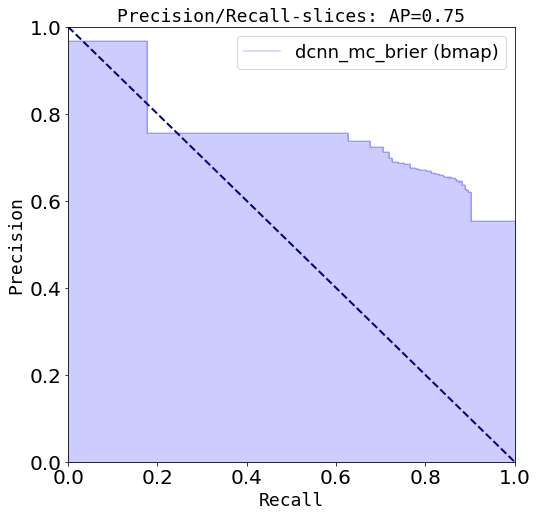

INFO - Successfully saved fig /home/jorg/expers/acdc/dcnn_mc_brier/figures/bmap/slices_roc.pdf


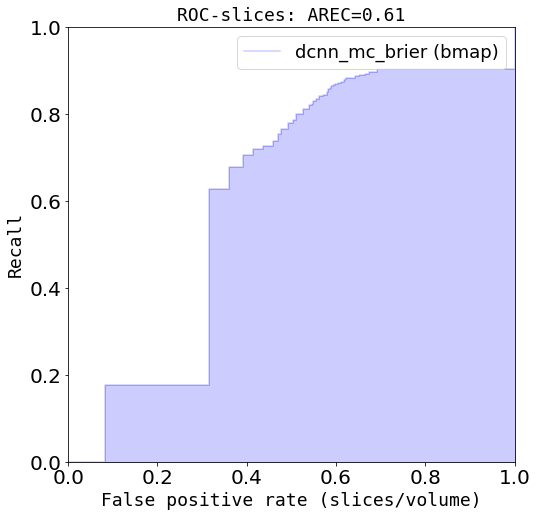

INFO - Successfully saved fig /home/jorg/expers/acdc/dcnn_mc_brier/figures/bmap/slices_froc.pdf


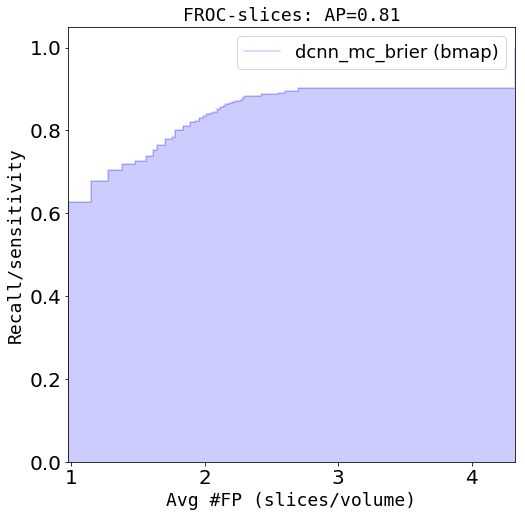

INFO - Successfully saved fig /home/jorg/expers/acdc/dcnn_mc_brier/figures/bmap/voxel_froc_detection_rate.pdf


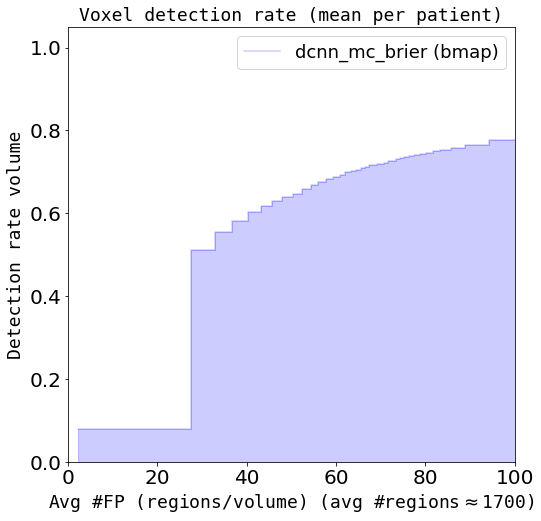

In [62]:
from datasets.ACDC.detection.load_result_objects import load_results

seg_model = "dcnn_mc_brier"
input_channels = "bmap"
do_save = True
model_tag = "{} ({})".format(seg_model, input_channels)
src_data_path = os.path.expanduser("~/expers/acdc/" + seg_model + "/dt_results/")
figure_dir =  os.path.expanduser("~/expers/acdc/" + seg_model + "/figures/" + input_channels)

results = load_results(src_data_path, input_channels)


slice_sensitivity, slice_precision, slice_fp_rate, slice_fp, \
    region_sensitivity, region_precision, region_fp_rate, region_fp, detection_rate, thresholds = \
    compute_detection_performance(results, nbr_of_thresholds=40,
                                        cardiac_phase="ES", range_threshold=[0, 1.])

plot_detection_auc_curves(slice_precision, slice_sensitivity, slice_fp, slice_fp_rate,
                          detection_rate, region_fp, do_save=do_save,
                          output_dir=figure_dir, model_tag=model_tag)

### Compute detection statistics

In [9]:
slice_sensitivity, slice_precision, slice_fp_rate, slice_fp, \
    region_sensitivity, region_precision, region_fp_rate, region_fp, detection_rate, thresholds = \
    compute_detection_performance(eval_handler.results, nbr_of_thresholds=40,
                                        cardiac_phase="ES", range_threshold=[0, 1.])




Average % of slices with errors 42.85
Average #regions/volume 1787.52


### Create figures

/home/jorg/expers/acdc/unet_mc_dice/dt_logs/f0_rsn_mc_bmap_08_0085_0812_181559/results
INFO - Successfully saved fig /home/jorg/expers/acdc/unet_mc_dice/dt_logs/f0_rsn_mc_bmap_08_0085_0812_181559/figures/slices_prec_recall.pdf


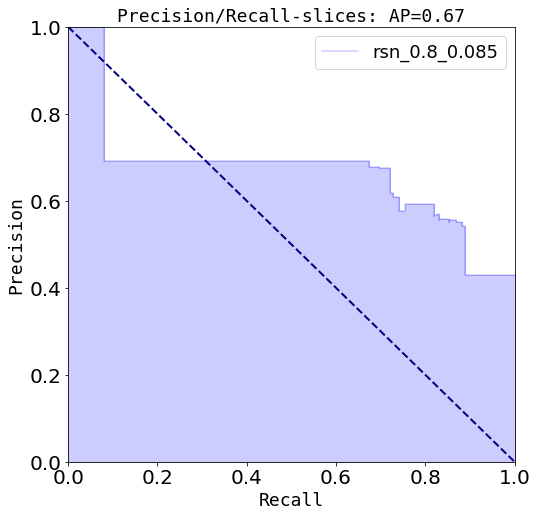

INFO - Successfully saved fig /home/jorg/expers/acdc/unet_mc_dice/dt_logs/f0_rsn_mc_bmap_08_0085_0812_181559/figures/slices_roc.pdf


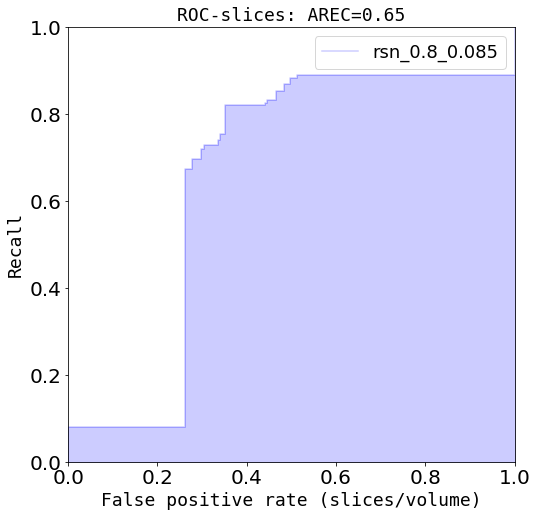

INFO - Successfully saved fig /home/jorg/expers/acdc/unet_mc_dice/dt_logs/f0_rsn_mc_bmap_08_0085_0812_181559/figures/slices_froc.pdf


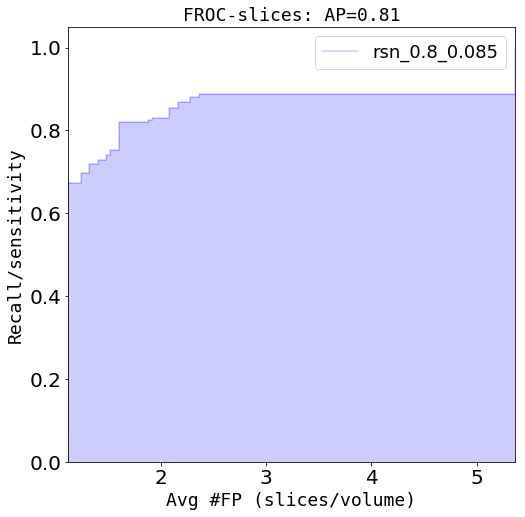

INFO - Successfully saved fig /home/jorg/expers/acdc/unet_mc_dice/dt_logs/f0_rsn_mc_bmap_08_0085_0812_181559/figures/voxel_froc_detection_rate.pdf


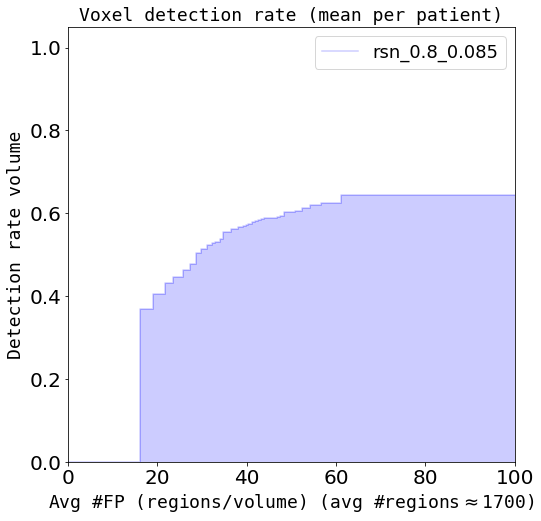

In [15]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from plotting.auc_curves import plot_detection_auc_curves

do_save = True
print(eval_handler.output_dir_results)

plot_detection_auc_curves(slice_precision, slice_sensitivity, slice_fp, slice_fp_rate,
                          detection_rate, region_fp, do_save=do_save,
                          output_dir=eval_handler.figure_dir, model_tag=eval_handler.model_tag)



# Not anymore in use

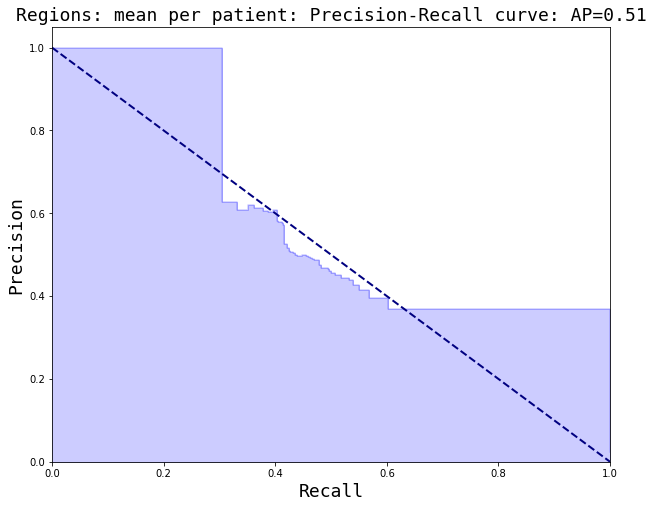

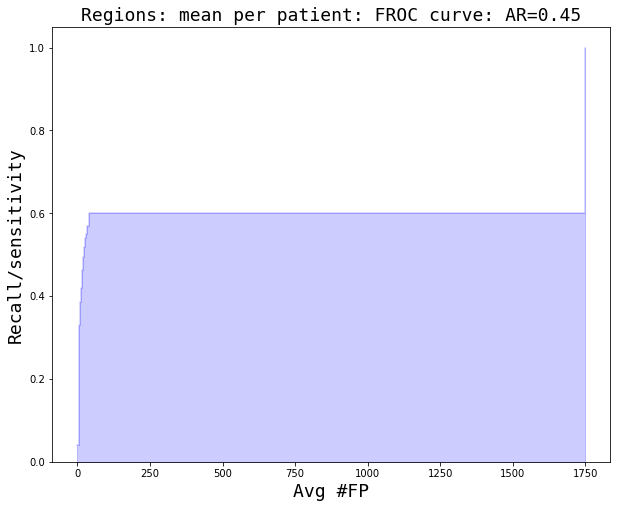

In [69]:
from sklearn.metrics import precision_recall_curve
# from sklearn.utils.fixes import signature
from inspect import signature
from sklearn.metrics import average_precision_score

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})


precision = np.array([1] + region_precision)
recall = np.array([0] + region_sensitivity)
average_precision = np.mean(region_precision)

fig = plt.figure(figsize=(10, 8))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlabel('Recall', **config_detector.axis_font18)
plt.ylabel('Precision', **config_detector.axis_font18)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Regions: mean per patient: Precision-Recall curve: AP={0:0.2f}'.format(average_precision), **config_detector.axis_font18)
plt.show()

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})


false_positives = region_fp 
recall = region_sensitivity
average_precision = np.mean(region_sensitivity)

fig = plt.figure(figsize=(10, 8))
plt.step(false_positives, recall, color='b', alpha=0.2, where='post')
plt.fill_between(false_positives, recall, alpha=0.2, color='b', **step_kwargs)

plt.ylabel('Recall/sensitivity', **config_detector.axis_font18)
plt.xlabel('Avg #FP', **config_detector.axis_font18)
plt.ylim([0.0, 1.05])

plt.title('Regions: mean per patient: FROC curve: AR={0:0.2f}'.format(average_precision), **config_detector.axis_font18)
plt.show()

In [ ]:
from utils.froc import compute_froc, load_froc_data

pred_probs = eval_batch_rd1.flatten_batch_probs()
gt_labels = np.array(eval_batch_rd1.batch_gt_labels)
base_apex_labels = np.array(eval_batch_rd1.batch_extra_labels)
num_of_slices = len(eval_batch_rd1.batch_slice_gt_labels)

threshold_sensitivity_rd1, threshold_precision_rd1, threshold_fp_rd1, threshold_fp_rate_rd1,  \
                slice_sensitivity_rd1, slice_threshold_precision_rd1, slice_fp_rd1, slice_threshold_fp_rate, \
                threshold_list_rd1, num_of_slices, num_of_grids = \
                compute_froc(pred_probs, gt_labels, nbr_of_thresholds=200, range_threshold=None,
                             slice_probs_dict=eval_batch_rd1.batch_slice_pred_probs ,
                             slice_labels_dict=eval_batch_rd1.batch_slice_gt_labels, exper_handler=exp_handler_rd1,
                             base_apex_labels=None, loc=0)  # base_apex_labels
    
gt_slice_labels = np.hstack(eval_batch_rd1.batch_slice_gt_labels.values())
batch_labels_apex_base = np.array(eval_batch_rd1.batch_extra_labels)

slices_containing_regions = np.count_nonzero(gt_slice_labels)
base_apex_containing_regions = np.count_nonzero(np.logical_and(gt_slice_labels, batch_labels_apex_base))

print("Slices containint regions {}. Base/apex of these {}".format(slices_containing_regions, 
                                                                   base_apex_containing_regions))
    
print("Ready")

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

precision, recall, _ = precision_recall_curve(gt_labels, pred_probs)
average_precision = average_precision_score(gt_labels, pred_probs)

fig = plt.figure(figsize=(10, 8))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall', **config_detector.axis_font18)
plt.ylabel('Precision', **config_detector.axis_font18)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Regions: Precision-Recall curve: AP={0:0.2f}'.format(average_precision), **config_detector.axis_font18)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.utils.fixes import signature

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

width = 20
height =20
fig = plt.figure(figsize=(width, height))
x_values = np.linspace(0, 1., 50)

ax1 = plt.subplot2grid((6, 6), (0, 0), rowspan=2, colspan=2)
perc_fp = threshold_fp_rd1[::-1] * 1./num_of_grids * 100
ax1.step(perc_fp, threshold_sensitivity_rd1[::-1], color='b', alpha=0.2, where='post')
ax1.fill_between(perc_fp, threshold_sensitivity_rd1[::-1], alpha=0.2, color='b', **step_kwargs)
ax1.set_ylim([0., 1.])
ax1.set_xlabel("FP(% of all regions)", **config_detector.axis_font18)
ax1.set_ylabel("Sensitivity", **config_detector.axis_font18)
ax1.set_title("FROC regions", **config_detector.axis_font18)
# ax1.plot(threshold_fp_rd3[::-1], threshold_sensitivity_rd3[::-1], c='r')
ax2 = plt.subplot2grid((6, 6), (0, 2), rowspan=2, colspan=2)
perc_fp_slice = slice_fp_rd1[::-1] * 1./num_of_slices * 100
ax2.step(perc_fp_slice, slice_sensitivity_rd1[::-1], alpha=0.2, color='b', where='post')
ax2.fill_between(perc_fp_slice, slice_sensitivity_rd1[::-1], color='b', alpha=0.2, **step_kwargs)
# ax2.set_xlim([0., 1.])
ax2.set_ylim([0., 1.])
ax2.set_xlabel("FP(% of all slices)", **config_detector.axis_font18)
ax2.set_title("FROC slices", **config_detector.axis_font18)
# precision/recall regions
ax3 = plt.subplot2grid((6, 6), (2, 0), rowspan=2, colspan=2)
ax3.step(threshold_sensitivity_rd1[::-1], threshold_precision_rd1[::-1], color='g', alpha=0.2, where='post')
ax3.fill_between(threshold_sensitivity_rd1[::-1], threshold_precision_rd1[::-1], alpha=0.2, color='g',  
                 **step_kwargs)
ax3.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
ax3.set_xlabel("Sensitivity", **config_detector.axis_font18)
ax3.set_ylabel("Precision", **config_detector.axis_font18)
ax3.set_xlim([0., 1.])
ax3.set_ylim([0., 1.])
ax3.set_title("PR-curve regions", **config_detector.axis_font18)
# precision/recall slices
ax4 = plt.subplot2grid((6, 6), (2, 2), rowspan=2, colspan=2)
ax4.step(slice_sensitivity_rd1[::-1], slice_threshold_precision_rd1[::-1], alpha=0.2, color='g', where='post')
ax4.fill_between(slice_sensitivity_rd1[::-1], slice_threshold_precision_rd1[::-1], alpha=0.2, color='g',
                 **step_kwargs)
ax4.set_xlabel("Sensitivity", **config_detector.axis_font18)
ax4.set_xlim([0., 1.])
ax4.set_ylim([0., 1.])
ax4.set_title("PR-curve slices", **config_detector.axis_font18)
# ROC AUC
ax5 = plt.subplot2grid((6, 6), (4, 0), rowspan=2, colspan=2)

fpr, tpr, _ = roc_curve(gt_labels, pred_probs)

# ax5.step(threshold_fp_rate_rd1[::-1], threshold_sensitivity_rd1[::-1], alpha=0.2, color='y', where='post')
# ax5.fill_between(threshold_fp_rate_rd1[::-1], threshold_sensitivity_rd1[::-1], alpha=0.2, color='y',
#                 **step_kwargs)
ax5.step(fpr, tpr, alpha=0.2, color='y', where='post')
ax5.fill_between(fpr, tpr, alpha=0.2, color='y', **step_kwargs)

ax5.set_xlabel("False negative rate", **config_detector.axis_font18)
ax5.set_ylabel("True positive rate", **config_detector.axis_font18)
ax5.set_xlim([0., 1.])
ax5.set_ylim([0., 1.])
ax5.set_title("ROC AUC-curve regions", **config_detector.axis_font18)
# ROC AUC
ax6 = plt.subplot2grid((6, 6), (4, 2), rowspan=2, colspan=2)
ax6.step(slice_threshold_fp_rate[::-1], slice_sensitivity_rd1[::-1], alpha=0.2, color='y', where='post')
ax6.fill_between(slice_threshold_fp_rate[::-1], slice_sensitivity_rd1[::-1], alpha=0.2, color='y', 
                 **step_kwargs)
ax6.set_xlabel("False negative rate", **config_detector.axis_font18)
ax6.set_xlim([0., 1.])
ax6.set_ylim([0., 1.])
ax6.set_title("ROC AUC-curve slices", **config_detector.axis_font18)

# idx = np.where((perc_fp_rd1 >= 0.13) & (perc_fp_rd1 <= 0.14))
# print(idx)
# print(threshold_list_rd1[idx])
# print(slice_sensitivity_rd1[idx])
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


In [ ]:
def compute_tp_tn_fn_fp(result, reference):
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
        
    tp = np.count_nonzero(result & reference)
    tp_idx = result & reference
    fn = np.count_nonzero(~result & reference)
    fn_idx = ~result & reference
    tn = np.count_nonzero(~result & ~reference)
    tn_idx = ~result & ~reference
    fp = np.count_nonzero(result & ~reference)
    fp_idx = result & ~reference
    print(np.count_nonzero(fp_idx))
    return tuple((tp, tp_idx)), tuple((fn, fn_idx)), tuple((tn, tn_idx)), tuple((fp, fp_idx))


In [ ]:
from utils.dslices.accuracies import compute_eval_metrics

grid_spacing = 8
gt_labels = np.array(eval_batch.batch_gt_labels)
label_stats = np.array(eval_batch.target_labels_stats_per_roi[grid_spacing])

labels_stats_filtered_idx = np.logical_or(label_stats > 20., label_stats == 0)

pred_labels = np.array(eval_batch.batch_pred_labels)
pred_probs = eval_batch.flatten_batch_probs()

label_stats_filtered = label_stats[labels_stats_filtered_idx]
pred_labels_filtered = pred_labels[labels_stats_filtered_idx]
pred_probs_filtered = pred_probs[labels_stats_filtered_idx]
gt_labels_filtered = gt_labels[labels_stats_filtered_idx]

print(label_stats.shape, np.sum(label_stats), np.sum(label_stats_filtered), 
      np.count_nonzero(label_stats_filtered))

f1, roc_auc, pr_auc, prec, rec, fpr, tpr, precision, recall = \
            compute_eval_metrics(gt_labels_filtered, pred_labels_filtered, pred_probs_filtered)

tp_2, fn_2, tn_2, fp_2 = compute_tp_tn_fn_fp(pred_labels_filtered, gt_labels_filtered)
tp, fn, tn, fp = tp_2[0], fn_2[0], tn_2[0], fp_2[0]
print("roc_auc {:.3f} pr_auc {:.3f} Precision {:.3f} / Recall {:.3f}".format(roc_auc, pr_auc, 
                                                                             float(tp)/(tp+fp), 
                                                                             float(tp)/(tp + fn)))
tp_idx, fn_idx, tn_idx, fp_idx = tp_2[1], fn_2[1], tn_2[1], fp_2[1]

In [ ]:
grid_spacing = 8
gt_labels = np.array(eval_batch.batch_gt_labels)
label_stats = np.array(eval_batch.target_labels_stats_per_roi[grid_spacing])

total_num_grids = gt_labels.shape[0]
total_positives = np.count_nonzero(label_stats != 0)
total_negatives = total_num_grids - total_positives

print("Total #grids={}; #negatives={}; #positives={}".format(total_num_grids, total_negatives, total_positives))

pred_labels = np.array(eval_batch.batch_pred_labels)
pred_probs = eval_batch.flatten_batch_probs()

tp_2, fn_2, tn_2, fp_2 = compute_tp_tn_fn_fp(pred_labels, gt_labels)
tp, fn, tn, fp = tp_2[0], fn_2[0], tn_2[0], fp_2[0]
print("Precision {:.3f} / Recall {:.3f}".format(float(tp)/(tp+fp), float(tp)/(tp + fn)))
tp_idx, fn_idx, tn_idx, fp_idx = tp_2[1], fn_2[1], tn_2[1], fp_2[1]

label_stats_tp = label_stats[tp_idx]
label_stats_fn = label_stats[fn_idx]
label_stats_fp = label_stats[fp_idx]
pred_probs_tp = pred_probs[tp_idx]
print("Number of fp={} fn={}".format(fp, fn))
num_all_voxels = np.sum(label_stats)
print("Voxels all={}, tp={:.2f}, fn={:.2f}".format(num_all_voxels, np.sum(label_stats_tp)/num_all_voxels, 
                                           np.sum(label_stats_fn)/num_all_voxels))

label_hist, bin_edges = np.histogram(label_stats, bins=np.unique(label_stats))
label_hist_fn, _ = np.histogram(label_stats_fn, bins=np.unique(label_stats))
label_hist_tp, _ = np.histogram(label_stats_tp, bins=np.unique(label_stats))

print(bin_edges.shape, label_hist.shape, label_hist_fn.shape, label_hist_tp.shape)
plt.bar(bin_edges[2:], label_hist[1:], 0.5, align='center')
plt.title("#voxels in target area")
plt.xlabel("#positive voxels in target area")
plt.ylabel("frequency")
plt.show()

tp_percs = label_hist_tp / label_hist.astype(np.float)
fn_percs = label_hist_fn / label_hist.astype(np.float)

# Note: bin_edges = [  0.   1.   2.   3 ...] Hence, we omit the first 2 entries because we're not interested
#                                            in the "negatives" i.e. the areas that don't contain positive voxels

plt.bar(bin_edges[2:], tp_percs[1:], width=0.5, align='center', label="tp %")
plt.legend(loc="best")
plt.title("#voxels in target area for TP")
plt.xlabel("#positive voxels in target area")
plt.ylabel("frequency")
plt.show()

plt.bar(bin_edges[2:], fn_percs[1:], width=0.5, align='center', label="fn %")
plt.legend(loc="best")
plt.title("#voxels in target area for FN")
plt.xlabel("#positive voxels in target area")
plt.ylabel("frequency")
plt.show()

# make plot with x-axis #voxels (as-is) and y-axis mean-softmax per bin



# Experiment with Superpixels

In [293]:
from skimage.segmentation import slic, felzenszwalb, mark_boundaries, quickshift, find_boundaries
from scipy.ndimage import label as scipy_label
from scipy.ndimage.morphology import generate_binary_structure

mycmap_jet = transparent_cmap(plt.get_cmap('jet'))

In [265]:
def merge_with_superpixels(errors, super_pixels):
    unique_comps = np.unique(super_pixels)
    new_mask = np.zeros_like(errors)
    if np.sum(errors) != 0:
        for c in unique_comps:
            c_region = np.zeros_like(errors)
            c_region[super_pixels == c] = 1
            if np.sum(np.logical_and(errors, c_region)) != 0:
                new_mask[c_region == 1] = 1
    return new_mask
        

In [ ]:
eval_batch = eval_batch_rd1
patient_id="patient037"
pat_dataset_slice_ids = dataset.trans_dict[patient_id][1]


width = 16
height = 8 * len(pat_dataset_slice_ids)
rows = 2 * len(pat_dataset_slice_ids)
columns = 4
row = 0

fig = plt.figure(figsize=(width, height))

c_structure = generate_binary_structure(2, 1)

for idx in pat_dataset_slice_ids:
    p_id, pat_slice_id, cardiac_phase = eval_batch.data_set.test_patient_slice_id[idx]
    if cardiac_phase != 1:
        continue
    
    input_channels = np.squeeze(eval_batch.keep_batch_images[idx].data.cpu().numpy())
    target_labels = eval_batch.keep_batch_label_slices[idx]
    print(p_id, pat_slice_id, cardiac_phase, target_labels.shape)
    c, w, h = input_channels.shape
    input_channels = np.transpose(input_channels, (1, 2, 0))
    image_slice = input_channels[:, :, 0]
    umap = copy.deepcopy(input_channels[:, :, 1])
    # umap[umap < 0.1] = 0    
    image_slice_normed = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice))
    auto_mask_normed = copy.deepcopy(input_channels[:, :, 2])
    auto_mask_normed[input_channels[:, :, 2] == 1] = 0.1
    auto_mask_normed[input_channels[:, :, 2] == 2] = 0.3
    auto_mask_normed[input_channels[:, :, 2] == 3] = 0.6
    auto_mask_normed[input_channels[:, :, 2] == 4] = 0.9
    input_channels[:, :, 0] = image_slice_normed
    input_channels[:, :, 2] = auto_mask_normed
    super_pixel_input = np.concatenate((image_slice_normed[:, :, np.newaxis], auto_mask_normed[:, :, np.newaxis],
                                        auto_mask_normed[:, :, np.newaxis]),
                                       axis=2)
    # segments = slic(input_channels, n_segments=100, compactness=10, multichannel=True)
    segments_zwalb = felzenszwalb(super_pixel_input, scale=0.25, min_size=6)
    segments_quick = quickshift(super_pixel_input, convert2lab=True, max_dist=3, sigma=0.1)
    segments_slic = slic(input_channels, n_segments=200, compactness=10)
    # superpixel_image = mark_boundaries(image_slice_normed, segments_quick, mode="inner")
    segment_labels = segments_quick
    superpixel_image = find_boundaries(segments_quick, mode="inner", connectivity=1)
    new_error_mask = merge_with_superpixels(target_labels, segment_labels)
    ax1 = plt.subplot2grid((rows, columns), (row, 0), rowspan=2, colspan=2)
    ax1.imshow(segment_labels, cmap=cm.gray)
    ax1.imshow(target_labels, cmap=mycmap_jet)
    ax1.set_title("Slice {}".format(pat_slice_id))
    plt.axis("off")
    ax2 = plt.subplot2grid((rows, columns), (row, 2), rowspan=2, colspan=2)
    # ax1.imshow(target_labels, cmap=mycmap_jet)
    ax2.imshow(segment_labels, cmap=cm.gray)
    ax2.imshow(new_error_mask, cmap=mycmap_jet)
    plt.axis("off")
    row += 2
    # print(superpixel_image)